<a href="https://colab.research.google.com/github/gahaalt/cifar-vs-tensorflow2/blob/master/Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone repo and install TF 2.0

In [0]:
%%capture
!git clone https://github.com/gahaalt/cifar-vs-tensorflow2.git
!pip install --upgrade tensorflow-gpu

#### Import and load model

In [0]:
import os
import logging
logging.getLogger('tensorflow').disabled = True

try:
    os.chdir('cifar-vs-tensorflow2')
except:
    pass

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
if not tf.test.is_gpu_available():
    print("GPU is not available, change Runtime!")

import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from tensorflow.keras.utils import plot_model

In [0]:
from Models.Resnets import cifar_resnet20 as create_model
model = create_model(shortcut_type='B', block_type='original',)

#### Take a look at the model

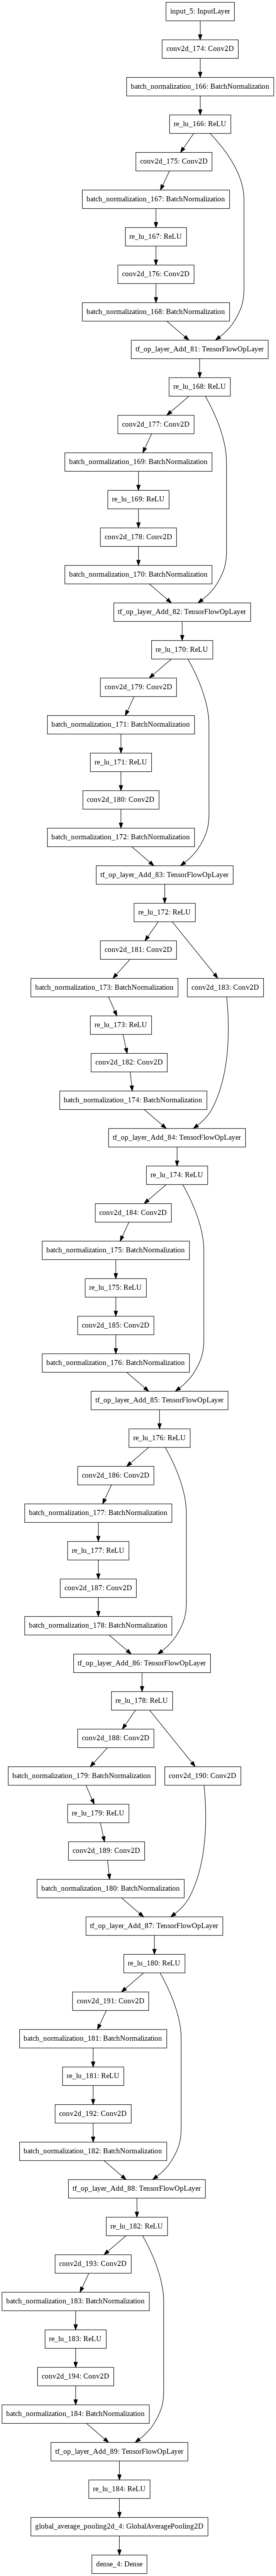

In [117]:
plot_model(model)

#### Define optimizer, data processing, etc...

In [0]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[400, 32000, 48000], values=[0.01, 0.1, 0.01, 0.001])
optimizer = tf.keras.optimizers.SGD(schedule, momentum=0.9)

model.compile(optimizer, loss_fn, metrics=['accuracy'])

ds = tfds.load('cifar10', as_supervised=True, in_memory=True)
std = tf.reshape((0.2023, 0.1994, 0.2010), shape=(1, 1, 3))
mean= tf.reshape((0.4914, 0.4822, 0.4465), shape=(1, 1, 3))

def train_prep(x, y):
    x = tf.cast(x, tf.float32)/255.
    x = tf.image.random_flip_left_right(x)
    x = tf.image.pad_to_bounding_box(x, 4, 4, 40, 40)
    x = tf.image.random_crop(x, (32, 32, 3))
    x = (x - mean) / std
    return x, y

def valid_prep(x, y):
    x = tf.cast(x, tf.float32)/255.
    x = (x - mean) / std
    return x, y

ds['train'] = ds['train'].map(train_prep).shuffle(5000).repeat().batch(128).prefetch(-1)
ds['test'] = ds['test'].map(valid_prep).batch(512).prefetch(-1)

# Training
Might be slow in Colab!

In [0]:
# Training parameters
training_steps = 64000
validation_interval = 2000

model.fit_generator(ds['train'], steps_per_epoch=validation_interval, epochs=training_steps//validation_interval, validation_data=ds['test'], workers=4)

# Testing

In [0]:
from Models.Resnets import cifar_resnet20 as create_model
model = create_model(block_type='original', load_weights=True)

#### Control accuracy on the test set

In [0]:
prediction = model.predict_generator(ds['test'])
prediction = tf.argmax(prediction, axis=-1)

ground_truth = tf.concat([y for x, y in ds['test']], 0)
print(f"Accuracy if the model: {np.mean(prediction==ground_truth) * 100:6.3f}")

Accuracy if the model: 91.490


#### Look at the predictions one by one

In [0]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

iterator = iter(ds['test'])
batch, targets = next(iterator)
preds = model.predict_on_batch(batch)

targets = targets.numpy()
batch = batch.numpy()
batch -= batch.min()
batch /= batch.max()

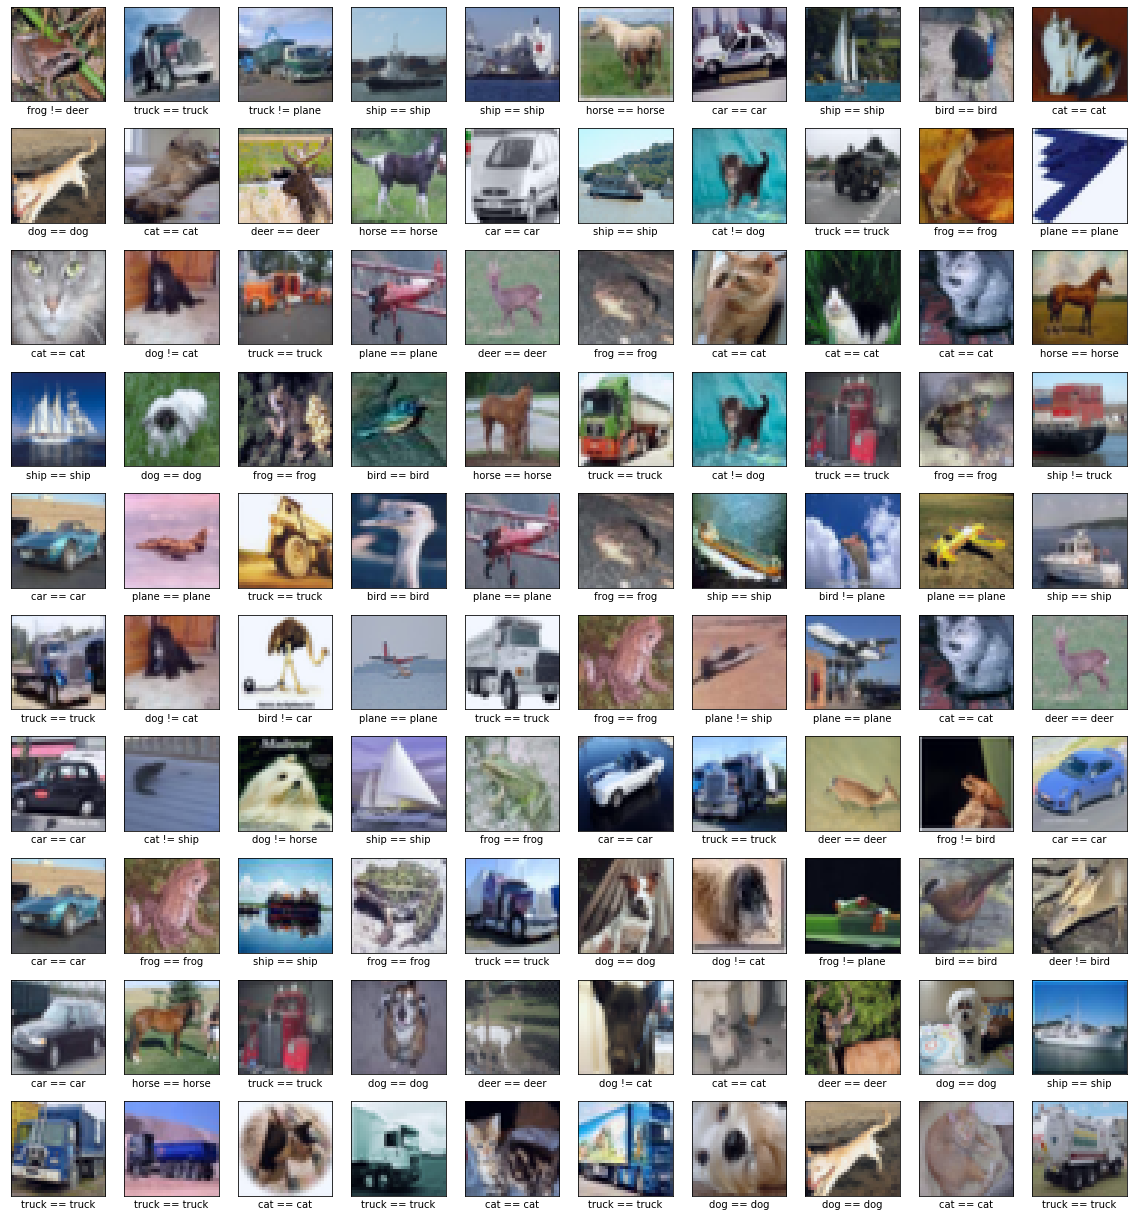

In [0]:
plt.figure(figsize=(20, 22))

for i in range(100):
    rnd_idx = np.random.randint(batch.shape[0])

    plt.subplot(10, 10, i+1)
    plt.imshow(batch[rnd_idx])
    plt.xticks([])
    plt.yticks([])

    true_class = class_names[targets[rnd_idx]]
    pred_class = class_names[preds[rnd_idx].argmax(-1)]
    
    if true_class == pred_class:
        plt.xlabel(true_class + ' == ' + pred_class)
    else:
        plt.xlabel(true_class + ' != ' + pred_class)


############################
# true_class == pred_class #
############################